In [1]:
import sys
import os

import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import virga.justdoit as vj
import virga.justplotit as cldplt
jpi.output_notebook()
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
%matplotlib inline
import xarray

Loading BokehJS ...

In [2]:
#1 ck tables from roxana
mh = '+000'#'+0.0' #log metallicity
CtoO = '100'#'1.0' # CtoO ratio

ck_db = f"../data/kcoeff_2020/sonora_2020_feh{mh}_co_{CtoO}.data.196"

#sonora bobcat cloud free structures file
sonora_profile_db = '../data/sonora_bobcat/structures_m+0.0'
sonora_dat_db = '../data/sonora_bobcat/structures_m+0.0'

In [3]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation

teff= 250 # Effective Temperature of your Brown Dwarf in K
grav = 316 # Gravity of your brown dwarf in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

opacity_ck = jdi.opannection(ck_db=ck_db) # grab your opacities

In [4]:
nlevel = 91 # number of plane-parallel levels in your code

#Lets set the max and min at 1e-4 bars and 500 bars

# Pmin = 1e-4 #bars
# Pmax = 200 #bars
# pressure=np.logspace(np.log10(Pmin),np.log10(Pmax),nlevel) # set your pressure grid

# temp_guess = np.zeros(shape=(nlevel)) + 500 # K , isothermal atmosphere guess

pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.dat"),
                            usecols=[1,2],unpack=True, skiprows = 1)

In [5]:
nofczns = 1 # number of convective zones initially

nstr_upper = 60 # top most level of guessed convective zone
nstr_deep = nlevel - 2 # this is always the case. Dont change this
# nstr = np.array([0,nstr_upper,nstr_deep,0,0,0]) # single convective zone

nstr = np.array([0,nstr_upper,nstr_deep,0,0,0])

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

In [10]:
cl_run.inputs_climate(temp_guess= temp_bobcat, pressure= pressure_bobcat,
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv, cloudy = "selfconsistent", mh = '0.0', 
                      CtoO = '1.0',species = ['H2O'], fsed = 8.0, beta = 0.1, virga_param = 'const',
                      mieff_dir = "~/projects/clouds/virga/refrind", do_holes = False, fhole = 0.5, fthin_cld = 0.9, moistgrad = False)

Cloudy functionality still in beta form and not ready for public use.


In [11]:
out = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True, verbose=False)

Iteration number  0 , min , max temp  109.7831852579274 1485.8033203746443 , flux balance  0.845415376125137
Iteration number  1 , min , max temp  17.185529205793173 1485.8033203746443 , flux balance  0.22757545422316638
Iteration number  2 , min , max temp  10.1 1485.8033203746443 , flux balance  0.04605852499986553
Iteration number  3 , min , max temp  26.58738636605075 1485.8033203746443 , flux balance  0.041630559446399
Iteration number  4 , min , max temp  38.982446207474446 1485.8033203746443 , flux balance  0.00517572112952117
Iteration number  5 , min , max temp  36.8903155644723 1485.8033203746443 , flux balance  0.0004084390888357721
Iteration number  6 , min , max temp  36.412134017636994 1485.8033203746443 , flux balance  1.687338317171038e-05
 We are already at a root, tolf , test =  5e-05 ,  1.691638002112343e-05
Overwriting some Kz values to minimum value set by kz_min 
                     You can always turn off these warnings by setting verbose=False
Max TAUCLD diff i

In [12]:
opa_mon = jdi.opannection()

hi_res = jdi.inputs(calculation="browndwarf") # start a calculation
teff= 400 # Effective Temperature of your Brown Dwarf in K
grav = 316 # Gravity of your brown dwarf in m/s/s
hi_res.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity

hi_res.atmosphere(df=out['ptchem_df'])
hi_res.clouds(df=out['cld_output_picaso'])

df_spec1 = hi_res.spectrum(opa_mon, calculation='thermal', full_output= True)

wno, fp = df_spec1['wavenumber'], df_spec1['thermal'] #erg/cm2/s/cm
xmicron = 1e4/wno

flamy = fp*1e-8  # per anstrom instead of per cm
sp = jdi.psyn.ArraySpectrum(xmicron, flamy,
                           waveunits='um',
                           fluxunits='FLAM')
sp.convert("um")
sp.convert('Fnu')  # erg/cm2/s/Hz

wno = sp.wave  # micron
fp = sp.flux  # erg/cm2/s/Hz
df_spec1['fluxnu'] = fp
wno,fp = jdi.mean_regrid(1e4/wno,fp, R=200)

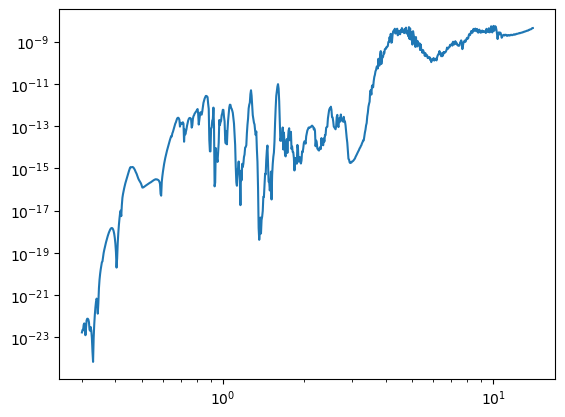

In [13]:
plt.loglog(1e4/wno,fp)
plt.show()